This code is for preprocessing images for removing letter artifacts (backgrounf noises) from the images.
We applied a contour based precosseing where, at first we find all regions in an image and then only keep 
the largest region (as we assumed that breast region is the largest region). Finally, we check the direction 
of the image and if find the image is L2R direction then we flip to R2L direction as most images R2L directed. 


In [1]:
import numpy as np
import pandas as pd
from PIL import Image 
import matplotlib.pyplot as plt 
import plotly.express as px
import cv2

In [4]:
metadata = pd.read_csv('/data/mammo/png_kheiron/kheiron_code/cohort_1/metadata_anon_cohort_1_ROI.csv')
magview = pd.read_csv('/data/mammo/png_kheiron/kheiron_code/cohort_1/mag_cohort_1_anon.csv')
cohort1_df = pd.merge(magview,metadata,on='acc_anon',how='inner')

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (8,26,31,46,47,51,54,55,57,59,79,81,82,83,91) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


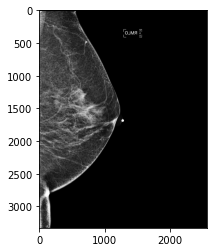

In [11]:
## Example image
plt.imshow(cv2.imread(cohort1_df['png_path'].iloc[0]), cmap = 'gray')
plt.show()

In [2]:
def checkflip(im):    
    
    if im.shape[1] % 2 ==1:
        im = im[:,:-1]
    else:
        im = im 
        
    h1, h2 = np.split(im,2, axis =1)
    
    if np.sum(h1) < np.sum(h2):        
        im = np.fliplr(im)
    else:
        im = im 
    return im    

In [3]:
def image_preprocessing(img_path):
    img = cv2.imread(img_path, 0) # reading in grayscale
    
    ## binarise masking 
    mask = np.zeros(img.shape, np.uint8)
    mask[img >= 1] = 255
    
    ## Fidning all the contours from the image
    contours, hierarchy = cv2.findContours(image= mask, 
                                           mode=cv2.RETR_EXTERNAL, 
                                           method=cv2.CHAIN_APPROX_NONE)
    
    ## sorting the contours in a descending order
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    # Get the top largest contours.
    number_of_highest_cont = 1 # how many contours should be retained by descending order
    largest_contours = sorted_contours[0:number_of_highest_cont]
    
    # canvas to draw the extracted contours
    canvas = np.zeros(mask.shape, np.uint8)
    
    # Draw contours in largest_contours.
    largest_regions = cv2.drawContours(image = canvas, 
                                       contours = largest_contours, 
                                       contourIdx = -1,  
                                       color = 1,  
                                       thickness = -1, 
                                      )
    
    cleaned_img = img.copy()
    cleaned_img[largest_regions == 0] = 0
    
    ### flipping the images if the the image breast is left to right
    final_result = checkflip(cleaned_img)
    ## normalizing the data
    final_result= final_result.astype("float32")/255
    
    return final_result

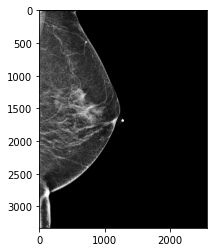

In [13]:
# noise removed image 
plt.imshow(image_preprocessing(cohort1_df['png_path'].iloc[0]), cmap = 'gray')
plt.show()